In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
base = "drive/My Drive/외부/공모전/[기상] AI프렌즈 시즌1 온도 추정 경진대회/"

data = pd.read_csv(os.path.join(base, "train.csv"))

### 똑같은 값만 나오는 센서 삭제

In [0]:
broken_cols = data.columns[data.max() == data.min()]
print(broken_cols)

for col in broken_cols:
  data = data.drop(columns=col)

Index(['X14', 'X16', 'X19'], dtype='object')


In [0]:
X_cols = [col for col in data.columns if 'X' in col]
Y_cols = ["Y{0:02}".format(i) for i in range(18)]

train = data[:4320]
val = data[4320:]

### 센서 데이터 시각화

In [0]:
sensors = {
  'temperature' : ["X00","X07","X28","X31","X32"], #기온
  'localpress'  : ["X01","X06","X22","X27","X29"], #현지기압
  'speed'       : ["X02","X03","X18","X24","X26"], #풍속
  'water'       : ["X04","X10","X21","X36","X39"], #일일 누적강수량
  'press'       : ["X05","X08","X09","X23","X33"], #해면기압
  'sun'         : ["X11","X34"], #일일 누적일사량
  'humidity'    : ["X12","X20","X30","X37","X38"], #습도
  'direction'   : ["X13","X15","X17","X25","X35"], #풍향
}

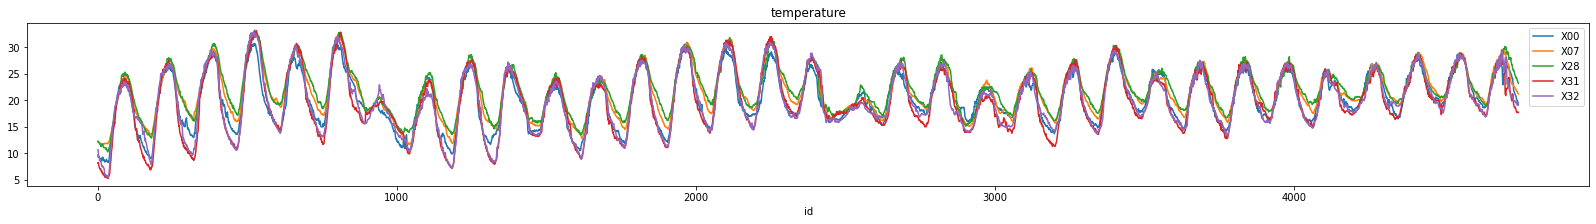

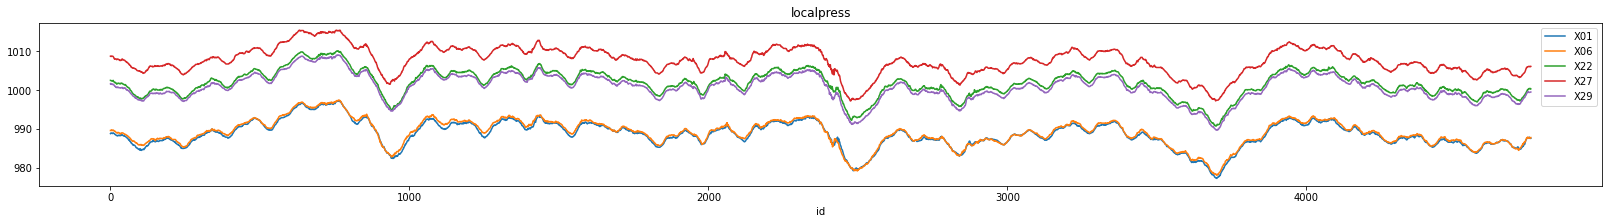

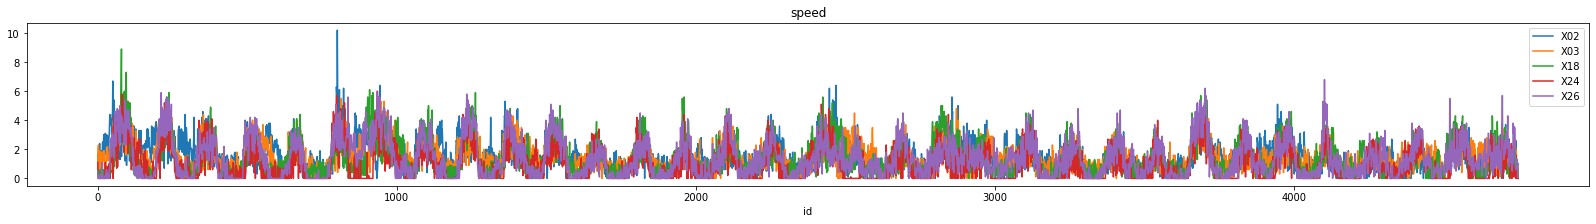

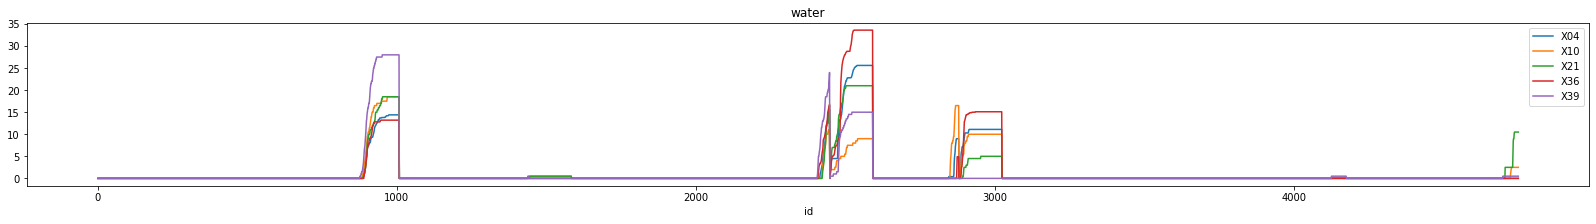

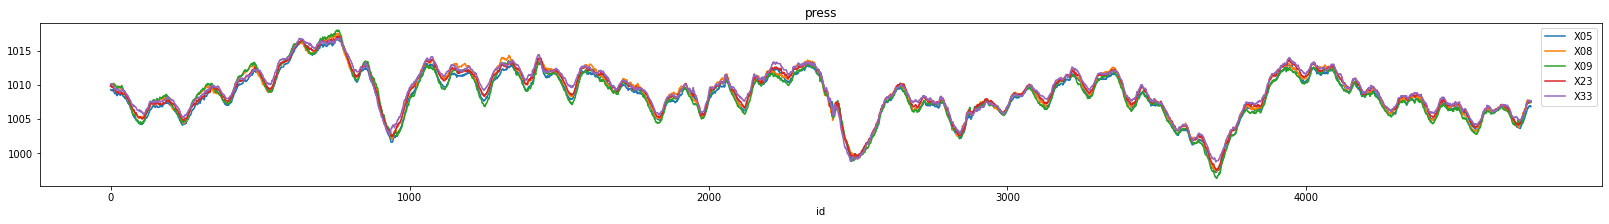

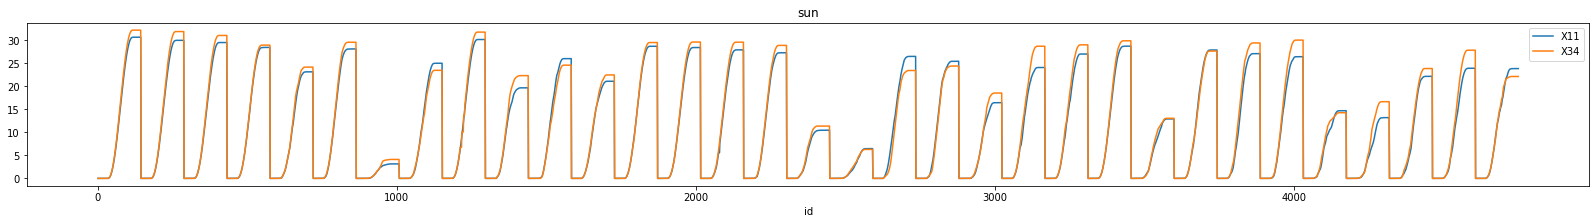

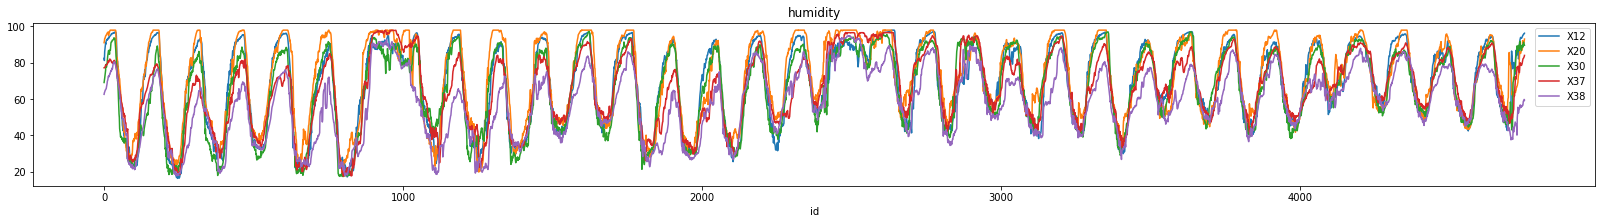

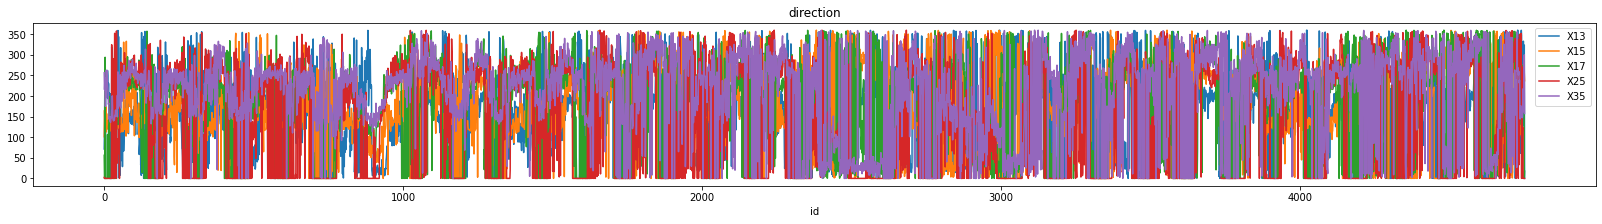

In [0]:
for name, cols in sensors.items():
  data.plot(x='id', y=cols, figsize=(28,3), title=name)

### Feature Selection

In [0]:
def forward_selection(clf, dataset, X_cols):
  sfs = SFS(clf, 
            k_features=len(X_cols), 
            forward=True, 
            floating=False, 
            scoring='neg_mean_squared_error', 
            cv=10)

  sfs = sfs.fit(dataset[X_cols], dataset['Y18'])
  fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
  plt.title('Sequential Forward Selection (w. StdErr)')
  plt.grid()
  plt.show()

  return sfs

def print_good_features(sfs):
  metric = sfs.get_metric_dict()
  avg_scores = dict()
  max_key = None

  for key in metric.keys():
    avg_scores[metric[key]['feature_names']] = metric[key]['avg_score']

  for key, score in sorted(avg_scores.items(), key=lambda x: x[1], reverse=True)[:2]:
    if max_key is None: max_key = key
    
    print("feature_names: {}, avg_score: {}".format(key, score))

    return max_key

def check_cross_val_score(clf, dataset, X_cols, cv=5):
  scores = cross_val_score(clf, val[X_cols], val['Y18'], cv=cv)

  print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### LinearRegression을 이용한 forward Seletion

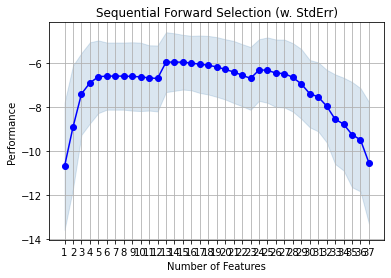

feature_names: ('X02', 'X04', 'X05', 'X12', 'X17', 'X22', 'X23', 'X26', 'X29', 'X30', 'X35', 'X36', 'X37', 'X38'), avg_score: -5.9594847740007335


In [0]:
sfs = forward_selection(LinearRegression(), val, X_cols)
features = print_good_features(sfs)

In [0]:
lr_feature_name = list(features)
check_cross_val_score(LinearRegression(), val, lr_feature_name)

Accuracy: 0.70 (+/- 0.43)


### Ridge을 이용한 forward Seletion

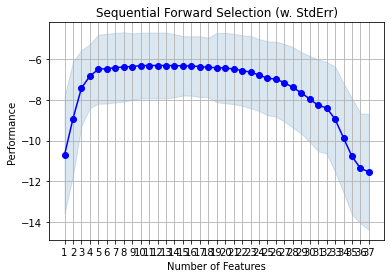

feature_names: ('X05', 'X06', 'X08', 'X12', 'X22', 'X23', 'X29', 'X30', 'X35', 'X36', 'X37', 'X38'), avg_score: -6.303022288469515


In [0]:
sfs = forward_selection(Ridge(alpha=1.0), val, X_cols)
features = print_good_features(sfs)

In [0]:
ridge_feature_name = list(features)
check_cross_val_score(Ridge(alpha=1.0), val, ridge_feature_name)

Accuracy: 0.74 (+/- 0.19)


### Univariate Selection
- Ref: https://wikidocs.net/16599

In [0]:
from sklearn.feature_selection import SelectKBest, f_classif

selectK = SelectKBest(score_func=f_classif, k=8)
X = selectK.fit_transform(val[X_cols], val['Y18'])

for col in X_cols:
  if list(val[col])[0] in X[0]:
    print("'{}'".format(col), end=", ")
print()

'X00', 'X07', 'X12', 'X20', 'X30', 'X31', 'X32', 'X37', 


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 4 33] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


### Feature Importance

In [0]:
from sklearn.feature_selection import RFE

model = LinearRegression()
rfe = RFE(model, 8)
fit = rfe.fit(val[X_cols], val['Y18'])

print(f"Num Features: {fit.n_features_}")
print(f"Selected Features: {np.array(X_cols)[fit.support_]}")
print(f"Feature Ranking: {np.array(X_cols)[fit.ranking_]}")

Num Features: 8
Selected Features: ['X01' 'X06' 'X09' 'X23' 'X27' 'X29' 'X33' 'X39']
Feature Ranking: ['X13' 'X01' 'X27' 'X23' 'X32' 'X17' 'X01' 'X03' 'X06' 'X01' 'X25' 'X05'
 'X24' 'X29' 'X30' 'X31' 'X18' 'X21' 'X11' 'X15' 'X01' 'X22' 'X28' 'X10'
 'X01' 'X08' 'X01' 'X12' 'X02' 'X20' 'X01' 'X04' 'X26' 'X33' 'X07' 'X09'
 'X01']


### recursive feature elimination
- 재귀적으로 특징 제거
- 시간이 오래 걸린다

In [0]:
# from sklearn.feature_selection import RFE
# from sklearn.svm import SVR
# estimator = SVR(kernel="linear")
# selector = RFE(estimator, 5, step=1)
# selector = selector.fit(val[X_cols], val['Y18'])

# print(f"Selected Features: {np.array(X_cols)[selector.support_]}")
# print(f"Feature Ranking: {np.array(X_cols)[selector.ranking_]}")

### Model Selection

In [0]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('classifier', LogisticRegression())])

param_grid = [{'classifier': [SVR()], 
              'classifier__gamma': [0.01, 0.1, 1, 10, 100], 
              'classifier__C': [0.01, 0.1, 1, 10, 100]
              },

               {'classifier': [LogisticRegression()],
               'classifier__penalty': ['l1', 'l2'], 
               'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
               },

              {'classifier': [RandomForestClassifier()],
              'classifier__max_depth': [4, 6], # max_depth: The maximum depth of the tree.
              'classifier__n_estimators': [50, 100], # n_estimators: The number of trees in the forest.
              'classifier__min_samples_split': [50, 100]
              }] # min_samples_split: The minimum number of samples required to split an internal node       

grid = GridSearchCV(pipe, param_grid, scoring = 'roc_auc', cv=5)  
grid.fit(val[X_cols], val['Y18'])

print(grid.best_params_)
print(grid.best_score_)

In [0]:
feature_names = {'lr': lr_feature_name,
                 'ridge': ridge_feature_name}

### lightbgm으로 예측하기

In [0]:
train['Y18'] = train[Y_cols].mean(axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
def train_lgb(dataset, X_cols, Y_col='Y18'):
    lgb_train = lgb.Dataset(dataset[X_cols], label=dataset[Y_col])

    lgb_param = {
        'objective': 'regression',
        'metrics': 'mae',
        'learning_rate' : 0.01
    }

    cv_result = lgb.cv(
        lgb_param,
        lgb_train,
        num_boost_round=99999,
        nfold = 5,
        early_stopping_rounds=10,
        stratified=False,
        verbose_eval=10
    )

    lgb_model = lgb.train(
      lgb_param,
      lgb_train,
      num_boost_round=len(cv_result['l1-mean'])
    )

    return lgb_model

def get_val_accuracy(clf, X_cols, Y_col='Y18'):
  pred = clf.predict(val[X_cols])
  mae = mean_absolute_error(val[Y_col], pred)

  return mae

def submit(clf, X_cols, name="None"):
  submit = pd.read_csv(base + 'sample_submission.csv')
  test = pd.read_csv(base + "test.csv")
  submit['Y18'] = clf.predict(test[X_cols])

  submit.to_csv(os.path.join(base, "제출", name + ".csv"), index=None)

In [0]:
results = dict()

for name, features in feature_names.items():
  lgb_model = train_lgb(train, features)

  val_accuracy = get_val_accuracy(lgb_model, features)

  print(f"feature_name: {name}, val_accracy: {val_accuracy}")
  results[name] = val_accuracy

[10]	cv_agg's l1: 5.65524 + 0.0568645
[20]	cv_agg's l1: 5.18907 + 0.0539343
[30]	cv_agg's l1: 4.77231 + 0.0519556
[40]	cv_agg's l1: 4.40066 + 0.0524448
[50]	cv_agg's l1: 4.07172 + 0.0523038
[60]	cv_agg's l1: 3.78203 + 0.0516408
[70]	cv_agg's l1: 3.52897 + 0.050672
[80]	cv_agg's l1: 3.30894 + 0.0509413
[90]	cv_agg's l1: 3.11618 + 0.0529655
[100]	cv_agg's l1: 2.94905 + 0.0544663
[110]	cv_agg's l1: 2.80382 + 0.0554339
[120]	cv_agg's l1: 2.67833 + 0.0563467
[130]	cv_agg's l1: 2.56851 + 0.0557501
[140]	cv_agg's l1: 2.4724 + 0.0539799
[150]	cv_agg's l1: 2.38724 + 0.0522292
[160]	cv_agg's l1: 2.31219 + 0.0506768
[170]	cv_agg's l1: 2.24486 + 0.050192
[180]	cv_agg's l1: 2.18362 + 0.0490217
[190]	cv_agg's l1: 2.1295 + 0.0490227
[200]	cv_agg's l1: 2.08052 + 0.047509
[210]	cv_agg's l1: 2.03764 + 0.0461566
[220]	cv_agg's l1: 1.99943 + 0.0458541
[230]	cv_agg's l1: 1.96487 + 0.0462742
[240]	cv_agg's l1: 1.93253 + 0.0455168
[250]	cv_agg's l1: 1.90297 + 0.0457144
[260]	cv_agg's l1: 1.87593 + 0.0457977


In [0]:
max_name = None

for name, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
  if max_name is None : max_name = name
  print(f"feature_name: {name}, val_accracy: {accuracy}")

feature_name: lr, val_accracy: 3.147615084257652
feature_name: ridge, val_accracy: 3.024774970519255


### Submit

In [0]:
total_data = pd.concat([train, val], axis=0)

In [0]:
lgb_model = train_lgb(total_data, feature_names[max_name])
submit(lgb_model, feature_names[max_name], "good_EDA_lightbgm")

[10]	cv_agg's l1: 5.6326 + 0.0877624
[20]	cv_agg's l1: 5.17627 + 0.0810996
[30]	cv_agg's l1: 4.76602 + 0.0781375
[40]	cv_agg's l1: 4.4 + 0.0738074
[50]	cv_agg's l1: 4.07765 + 0.067017
[60]	cv_agg's l1: 3.79548 + 0.0612308
[70]	cv_agg's l1: 3.54701 + 0.0560309
[80]	cv_agg's l1: 3.32828 + 0.0499203
[90]	cv_agg's l1: 3.13962 + 0.046568
[100]	cv_agg's l1: 2.97649 + 0.0450411
[110]	cv_agg's l1: 2.83581 + 0.0436482
[120]	cv_agg's l1: 2.71452 + 0.0438865
[130]	cv_agg's l1: 2.60853 + 0.0442348
[140]	cv_agg's l1: 2.51503 + 0.0448756
[150]	cv_agg's l1: 2.43303 + 0.0455192
[160]	cv_agg's l1: 2.36014 + 0.0440287
[170]	cv_agg's l1: 2.29536 + 0.0421469
[180]	cv_agg's l1: 2.23886 + 0.0394885
[190]	cv_agg's l1: 2.18819 + 0.0383475
[200]	cv_agg's l1: 2.14266 + 0.037838
[210]	cv_agg's l1: 2.10275 + 0.0369535
[220]	cv_agg's l1: 2.06786 + 0.0370358
[230]	cv_agg's l1: 2.03541 + 0.0373154
[240]	cv_agg's l1: 2.00536 + 0.038693
[250]	cv_agg's l1: 1.9781 + 0.0405111
[260]	cv_agg's l1: 1.95219 + 0.0416297
[270]